In [14]:
import numpy as np
# from sklearn.datasets import load_digits
from scipy.spatial.distance import pdist
# from sklearn.manifold import t_sne
from scipy import linalg
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import squareform
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import os
import kaldi_io
import torch
from tqdm import tqdm
from scipy.stats import norm
import statistics
from scipy import stats
import pandas as pd
import seaborn as sns


plt.rc('font', family='Times New Roman', weight='semibold')
# import seaborn as sns
# sns.set(rc={'figure.figsize':(11.7,8.27)})
# palette = sns.color_palette("bright", 10)

In [2]:
from Define_Model.TDNN.TDNN import TDNN_v5
from Define_Model.Loss.SoftmaxLoss import AdditiveMarginLinear

In [3]:
data_dir = '/home/work2020/yangwenhao/project/SpeakerVerification-pytorch'

tdnn_xvector_dir = 'Data/xvector/TDNN_v5/cnceleb/klfb_egs_baseline/arcsoft/Mean_STAP_em512_wd5e4_var/cnceleb_dev_epoch50_fix/test'
tdnn_xvector_dict = {}
with open(os.path.join(data_dir, tdnn_xvector_dir, 'xvectors.scp'), 'r') as f:
    for l in f.readlines():
        uid,upath = l.split()
        tdnn_xvector_dict[uid] = upath
    
spk2uid_dict = {}
for uid in tdnn_xvector_dict:
    sid,_,_,_ = uid.split('-')
    spk2uid_dict.setdefault(sid, []).append(uid)  

In [4]:
tdnn_ckp_dir = 'Data/checkpoint/TDNN_v5/cnceleb/klfb_egs_baseline/arcsoft/Mean_STAP_em512_wd5e4_var/checkpoint_50.pth'
tdnn_model = torch.load(data_dir +"/"+tdnn_ckp_dir)

In [5]:
model = TDNN_v5(num_classes=800, embedding_size=512, input_dim=40, alpha=0., input_norm='Mean',
                 encoder_type='STAP', block_type='basic', first_2d=False, stride=[1],
                 channels=[512, 512, 512, 512, 1500])
model.classifier = AdditiveMarginLinear(feat_dim=512, num_classes=800)

model.load_state_dict(tdnn_model['state_dict'])

<All keys matched successfully>

In [6]:
classifier_Center = tdnn_model['state_dict']['classifier.W'].cpu()
print(classifier_Center.shape)

classifier_Center[:,1].shape

torch.Size([512, 800])


torch.Size([512])

In [7]:
lstm_dir = '/home/work2020/yangwenhao/project/lstm_speaker_verification/data'

cnc_dir = 'cnceleb/dev/wav.scp'
spk_domain_dict = {}
domains = set([])

with open(os.path.join(lstm_dir, cnc_dir), 'r') as f:
    
    for l in f.readlines():
        uid,upath = l.split()
        
        sid, domain,_,_ = uid.split('-')
        domains.add(domain)
        if sid in spk_domain_dict:
            spk_domain_dict[sid].add(domain)
        else:
            spk_domain_dict[sid] = set([domain])

In [8]:
domains = list(domains)
domains.sort()
domain2idx = {uid:i for i,uid in enumerate(domains)}

spks = list(spk_domain_dict.keys())
spks.sort()
spk2idx = {sid:i for i,sid in enumerate(spks)}

In [9]:
print(list(spk_domain_dict.keys())[:10])

['id00000', 'id00001', 'id00002', 'id00003', 'id00004', 'id00005', 'id00006', 'id00007', 'id00008', 'id00009']


In [10]:
numofdomains_spk = 4
numofdomains = []
for sid in spks:
    numofdomains.append(len(spk_domain_dict[sid]))
    if len(spk_domain_dict[sid]) >= numofdomains_spk:
        print(sid, end='", "')
# id00004

id00038", "id00047", "id00061", "id00070", "id00094", "id00096", "id00100", "id00108", "id00113", "id00130", "id00138", "id00152", "id00182", "id00210", "id00217", "id00222", "id00223", "id00258", "id00291", "id00304", "id00305", "id00307", "id00346", "id00351", "id00374", "id00376", "id00392", "id00394", "id00404", "id00406", "id00410", "id00412", "id00436", "id00448", "id00453", "id00458", "id00459", "id00464", "id00472", "id00476", "id00482", "id00489", "id00491", "id00498", "id00500", "id00504", "id00510", "id00522", "id00523", "id00533", "id00550", "id00555", "id00556", "id00557", "id00559", "id00601", "id00623", "id00664", "id00687", "id00693", "id00702", "id00738", "id00740", "id00747", "id00757", "id00769", "

In [106]:
# spk_domain_dict['id00007']
all_sids = ["id00038", "id00094", "id00061", "id00070"]
all_sid2idx = {s: i for i,s in enumerate(all_sids)}

In [60]:
# all_sids = ["id00038"]

# plt.figure(figsize=(24,6))

spk2dom2cos = {}
spk2vectors = {}
allvectors = []

for i, this_sid in enumerate(all_sids):
    # ax = plt.subplot(1,len(all_sids),i+1)
    j=0
    
    one_xvectors_dict = {}
    one_xvectors = []
    one_xvectors_dom = []
    one_xvectors_dom2cos = {}
    one_xvectors_domidx = []
    this_spk_center = classifier_Center[:, spk2idx[this_sid]]
    
    for uid in spk2uid_dict[this_sid]:
        this_vector = kaldi_io.read_vec_flt(data_dir + '/'+ tdnn_xvector_dict[uid])
        this_cos = torch.nn.functional.cosine_similarity(this_spk_center, torch.tensor(this_vector), dim=0) 

        one_xvectors_dict[uid] = this_vector
        one_xvectors.append(this_vector)
        dom = uid.split('-')[1]
        one_xvectors_dom.append(dom)
        one_xvectors_dom2cos.setdefault(dom,[]).append(float(this_cos))
        one_xvectors_domidx.append(domain2idx[dom])
        
        allvectors.append([this_sid, this_vector, dom])

    # allvectors.extend(one_xvectors)
    one_xvectors = np.array(one_xvectors)
    spk2vectors[this_sid] = one_xvectors
    
#     one_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(one_xvectors)
#     one_xvectors_dom = np.array(one_xvectors_dom)
    
#     sns.scatterplot(data=one_xvectors_dom2cos)
    # sns.jointplot(data=one_xvectors_dom2cos,)
    
    # for dom in one_xvectors_dom2cos:
    #     idx = np.where(one_xvectors_dom==dom)
    #     ax.scatter(one_embedded[idx,0], one_embedded[idx,1], alpha=0.1) #c=one_xvectors_domidx, label=one_xvectors_dom,
    
    # ax = plt.subplot(2,len(all_sids),len(all_sids)+i+1)
#     ax.set_xticks([domain2idx[d] for d in domains], domains)
    
    # [ax.scatter([dom]*len(one_xvectors_dom2cos[dom]), one_xvectors_dom2cos[dom], alpha=0.1) for dom in one_xvectors_dom2cos]
    # sns.kdeplot(data=one_xvectors_dom2cos)

    # ax.tick_params(axis='x', labelrotation=30)
    # ax.set_ylim(0, 3.5)
    
    # ax.scatter(one_xvectors_dom2cos)
    
#     ax.legend(one_xvectors_dom)
#     print(set(one_xvectors_dom))
#     plt.legend(list(set(one_xvectors_dom)))

In [107]:
pd_allvectors = pd.DataFrame(allvectors,columns=['sid','vector', 'domain'])

vectors = np.array([i for i in pd_allvectors['vector'].values])
spkidxs = [all_sid2idx[s] for s in list(pd_allvectors['sid'].values)]

In [ ]:
list(pd_allvectors['sid'].values)

In [97]:
all_embeddeds = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(vectors)
#     one_xvectors_dom = np.array(one_xvectors_dom)


In [108]:
sns.scatterplot(data=all_embeddeds, hue=spkidxs)

ValueError: The following variable cannot be assigned with wide-form data: `hue`

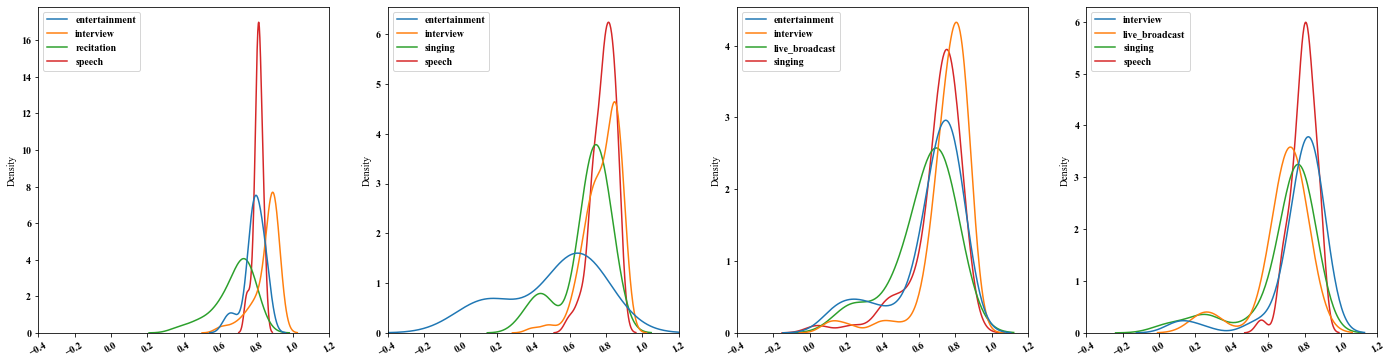

In [49]:
plt.figure(figsize=(24,6))

for i, this_sid in enumerate(all_sids):
    ax = plt.subplot(1,len(all_sids),i+1)
    j=0
    
    one_xvectors_dict = {}
    one_xvectors = []
    one_xvectors_dom = []
    one_xvectors_dom2cos = {}
    one_xvectors_domidx = []
    this_spk_center = classifier_Center[:, spk2idx[this_sid]]
    
    for uid in spk2uid_dict[this_sid]:
        this_vector = kaldi_io.read_vec_flt(data_dir + '/'+ tdnn_xvector_dict[uid])
#             print(this_vector.shape)
        this_cos = torch.nn.functional.cosine_similarity(this_spk_center, torch.tensor(this_vector), dim=0) 

        one_xvectors_dict[uid] = this_vector
        one_xvectors.append(this_vector)
        dom = uid.split('-')[1]
        one_xvectors_dom.append(dom)
        one_xvectors_dom2cos.setdefault(dom,[]).append(float(this_cos))
        one_xvectors_domidx.append(domain2idx[dom])
    
    sns.kdeplot(data=one_xvectors_dom2cos, common_norm=False)
    # sns.displot(one_xvectors_dom2cos, kind="kde", bw_adjust=.25)
    
    ax.tick_params(axis='x', labelrotation=30)
    # ax.set_ylim(0, 20)
    ax.set_xlim(-0.4, 1.2)
    
    # ax.scatter(one_xvectors_dom2cos)
#     ax.legend(one_xvectors_dom)
#     print(set(one_xvectors_dom))
#     plt.legend(list(set(one_xvectors_dom)))

In [12]:
miss_uid = []
all_cos = []
dom2cos = {}

for uid in tqdm(tdnn_xvector_dict, ncols=100):
    this_sid = uid.split('-')[0]
    this_spk_center = classifier_Center[:, spk2idx[this_sid]]

    this_vector = kaldi_io.read_vec_flt(data_dir + '/'+tdnn_xvector_dict[uid])
    this_cos = torch.nn.functional.cosine_similarity(this_spk_center, torch.tensor(this_vector), dim=0) 
    dom = uid.split('-')[1]
    dom2cos.setdefault(dom,[]).append(float(this_cos))
    
    all_cos.append(float(this_cos))

100%|██████████████████████████████████████████████████████| 91824/91824 [00:06<00:00, 15172.85it/s]


In [13]:
# plt.figure(figsize=(12,4))
# _ = plt.hist(all_cos, bins=100, density=True, cumulative=True,histtype='step')
# plt.xlim(0,1)

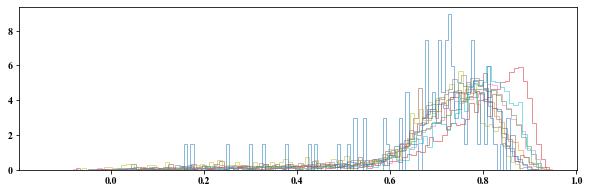

In [16]:
plt.figure(figsize=(10,3))
for i,dom in enumerate(dom2cos):
#     ax = plt.subplot(len(dom2cos),1,i+1)
    dom_cos = np.array(dom2cos[dom])
#     one_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(one_xvectors)
#     plt.scatter(dom_cos, [dom]*len(dom_cos), linewidths=0.1, alpha=0.2)
    plt.hist(dom_cos, alpha=0.5, bins=100, density=True, histtype='step')
    

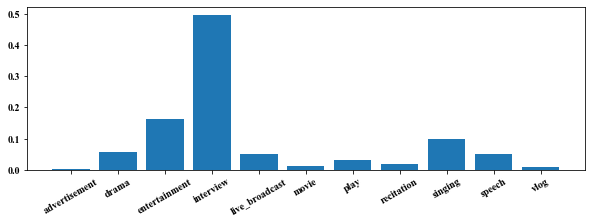

In [23]:
dom2num = []
plt.figure(figsize=(10,3))
for i,dom in enumerate(domains):
    dom2num.append(len(dom2cos[dom]))
    
plt.bar(domains, np.array(dom2num)/len(all_cos))
plt.tick_params(axis='x', labelrotation=30)

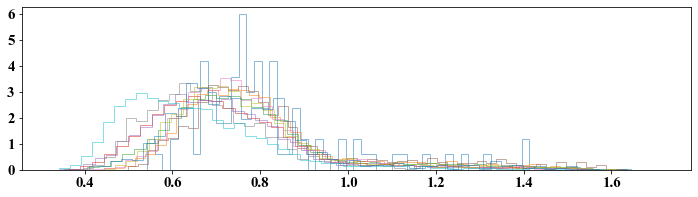

In [19]:
fontsize=15
plt.figure(figsize=(12,3))
for i,dom in enumerate(domains):
#     ax = plt.subplot(len(dom2cos),1,i+1)
    dom_cos = np.array(dom2cos[dom])
#     one_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(one_xvectors)
#     plt.scatter(dom_cos, [dom]*len(dom_cos), linewidths=0.1, alpha=0.2)
    _ = plt.hist(np.arccos(dom_cos), alpha=0.5, bins=50, density=True, histtype='step')

#     plt.legend(list(dom2cos.keys()), fontsize=fontsize) 
_ = plt.yticks(fontsize=fontsize)
_ = plt.xticks(fontsize=fontsize)

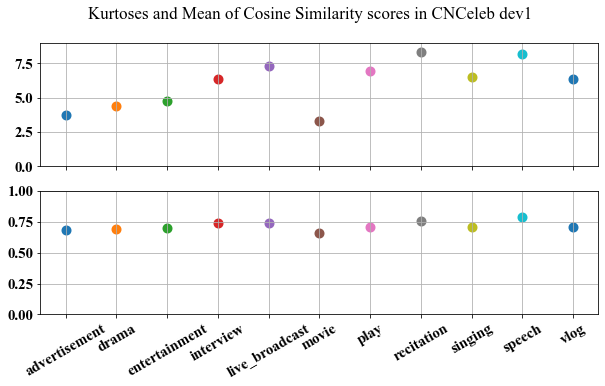

In [22]:
# x = np.arange(0, 2, 0.01)
plt.figure(figsize=(10,5))
plt.suptitle("Kurtoses and Mean of Cosine Similarity scores in CNCeleb dev1", fontsize=fontsize+2)
ax1 = plt.subplot(2,1,1)
ax2 = plt.subplot(2,1,2)
# ax3 = plt.subplot(3,1,3)

train_domain_stats = {}
for i,dom in enumerate(domains):
    dom_cos = np.array(dom2cos[dom])
    
    mean = dom_cos.mean()
    diffs = dom_cos - mean
    var = np.mean(np.power(diffs, 2.0))
    std = np.power(var, 0.5)
    z_scores = diffs / std

    kurtoses = np.mean(np.power(z_scores, 4.0)) - 3.0
    
#     kurtoses *= len(dom_cos)/all_cos
#     skewness = np.mean(np.power(z_scores, 3.0))
#     plt.plot(x, norm.pdf(x, mean, sd))
    
    ax1.scatter([dom], [kurtoses], marker='o', linewidth=4)
    ax2.scatter([dom], [mean], marker='o', linewidth=4)
#     ax3.scatter([dom], [std], marker='o', linewidth=4)
    
    train_domain_stats[dom] = [mean, std]
# plt.ylim(0,10)
# plt.xlim(0,1)
# ax1.set_xticks([])
ax1.set_xticklabels([])
# ax1.set_xticklabels([])
ax1.set_ylim(0,9)
ax2.set_ylim(0,1)
# ax2.set_xticklabels([])

for ax in [ax1, ax2]:
    ax.grid()
    
    ax.tick_params(axis='x', labelrotation=30)
    ax.tick_params(axis='both', labelsize=fontsize)
#     _ = ax.set_yticks(fontsize=fontsize)
#     _ = ax.set_xticks(fontsize=fontsize)
# plt.legend(list(dom2cos.keys()), fontsize=fontsize) 

# hard ==> easy

# movie adertisement drama entertainment
# vlog interview singing live_broadcast play 
# speech recitation

In [25]:
dom_center2cos = {}

for i, spk in enumerate(spk2uid_dict):
    uids = spk2uid_dict[spk]
    uids.sort()
    spk_domain_center = {}
    for uid in uids:
        dom = uid.split('-')[1]
        spk_domain_center.setdefault(dom, []).append(kaldi_io.read_vec_flt(data_dir + '/' +tdnn_xvector_dict[uid]))
    
    this_spk_center = classifier_Center[:, spk2idx[spk]]
    for dom in spk_domain_center:
        dom_center = np.array(spk_domain_center[dom])
#         print(dom_center.shape)
        dom_center = dom_center.mean(axis=0)
        this_cos = torch.nn.functional.cosine_similarity(this_spk_center, torch.tensor(dom_center), dim=0)
        dom_center2cos.setdefault(dom, []).append(float(this_cos))
        

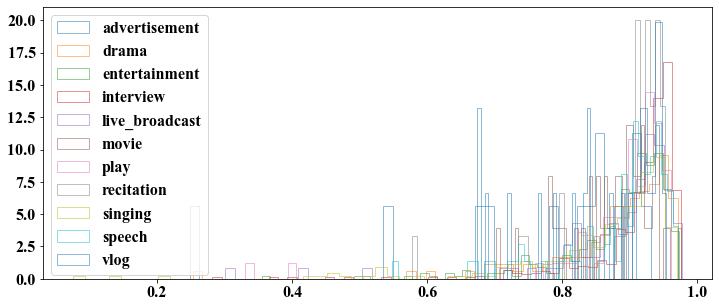

In [26]:
fontsize=16
plt.figure(figsize=(12,5))
for i,dom in enumerate(domains):
#     ax = plt.subplot(len(dom2cos),1,i+1)
    dom_cos = np.array(dom_center2cos[dom])
#     one_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(one_xvectors)
#     plt.scatter(dom_cos, [dom]*len(dom_cos), linewidths=0.1, alpha=0.2)
    _ = plt.hist(dom_cos, alpha=0.5, bins=50, density=True, histtype='step')

plt.legend(domains, fontsize=fontsize) 

_ = plt.yticks(fontsize=fontsize)
_ = plt.xticks(fontsize=fontsize)

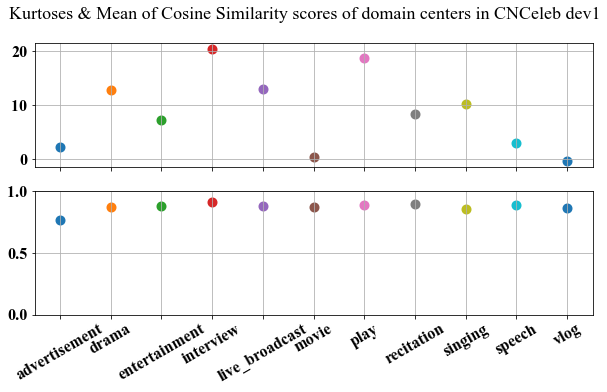

In [27]:
plt.figure(figsize=(10,5))
plt.suptitle("Kurtoses & Mean of Cosine Similarity scores of domain centers in CNCeleb dev1", fontsize=fontsize+2)
ax1 = plt.subplot(2,1,1)
ax2 = plt.subplot(2,1,2)

domain_kurtoses = []

for i,dom in enumerate(domains):
    dom_cos = np.array(dom_center2cos[dom])
    
    mean = dom_cos.mean()
    diffs = dom_cos - mean
    var = np.mean(np.power(diffs, 2.0))
    std = np.power(var, 0.5)
    z_scores = diffs / std
    
    kurtoses = np.mean(np.power(z_scores, 4.0)) - 3.0
    domain_kurtoses.append(kurtoses)
    ax1.scatter([dom], [kurtoses], marker='o', linewidth=4)
    ax2.scatter([dom], [mean], marker='o', linewidth=4)
    
ax1.set_xticklabels([])
ax2.set_ylim(0,1)
for ax in [ax1, ax2]:
    ax.grid()
    
    ax.tick_params(axis='x', labelrotation=30)
    ax.tick_params(axis='both', labelsize=fontsize)
# plt.legend(list(dom2cos.keys()), fontsize=fontsize) 

# Hard ==> Easy

# movie adertisement drama entertainment
# vlog interview singing live_broadcast play 
# speech recitation

In [30]:
spk_center2cos = []

for i, spk in enumerate(spks):
    uids = spk2uid_dict[spk]
    spk_center = []
    for uid in uids:
        spk_center.append(kaldi_io.read_vec_flt(data_dir + '/' +tdnn_xvector_dict[uid]))
    
    this_spk_center = classifier_Center[:, spk2idx[spk]]
    center = np.array(spk_center).mean(axis=0)
    this_cos = torch.nn.functional.cosine_similarity(this_spk_center, torch.tensor(center), dim=0)
    if this_cos < 0.7:
        print(spk)
    spk_center2cos.append(float(this_cos))
   

id00098
id00202
id00277
id00347
id00602
id00753
id00798


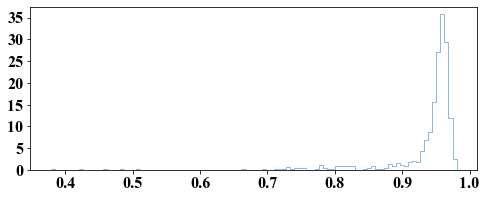

In [31]:
fontsize=16
plt.figure(figsize=(8,3))

center2cos = np.array(spk_center2cos)
#     one_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(one_xvectors)
#     plt.scatter(dom_cos, [dom]*len(dom_cos), linewidths=0.1, alpha=0.2)
plt.hist(center2cos, alpha=0.5, bins=100, density=True, histtype='step')
# plt.legend(domains, fontsize=fontsize) 

_ = plt.yticks(fontsize=fontsize)
_ = plt.xticks(fontsize=fontsize)

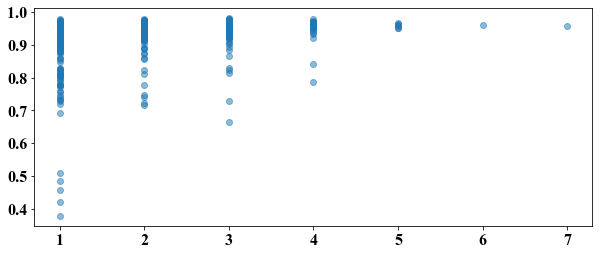

In [32]:
fontsize=16
plt.figure(figsize=(10,4))

center2cos = np.array(spk_center2cos)
#     one_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(one_xvectors)
#     plt.scatter(dom_cos, [dom]*len(dom_cos), linewidths=0.1, alpha=0.2)
# plt.hist(center2cos, alpha=0.5, bins=800, density=True, histtype='step')

plt.scatter(numofdomains, center2cos, alpha=0.5)
# plt.legend(domains, fontsize=fontsize) 

_ = plt.yticks(fontsize=fontsize)
_ = plt.xticks(fontsize=fontsize)

1 :  230
2 :  300
3 :  204
4 :  58
5 :  6
6 :  1
7 :  1


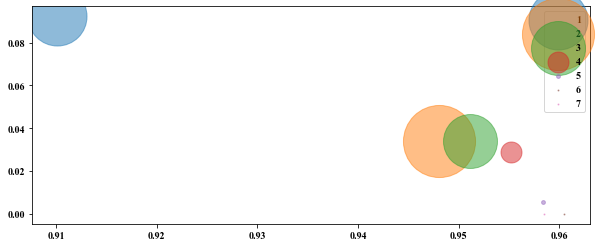

In [33]:
numofdomian2cos = {}
plt.figure(figsize=(10,4))

for n,c in zip(numofdomains, center2cos):
    numofdomian2cos.setdefault(n, []).append(c)

for i in range(1,8):
    mean = np.mean(numofdomian2cos[i])
    std = np.std(numofdomian2cos[i])
    print(i,': ', len(numofdomian2cos[i]))
    plt.scatter(mean, std, len(numofdomian2cos[i])**1.5, alpha=0.5)
    
plt.legend([str(i) for i in range(1,8)])

In [34]:
tdnn_test_score_f = 'Data/xvector/TDNN_v5/cnceleb/klfb_egs_baseline/arcsoft/Mean_STAP_em512_wd5e4_var/test/epoch_50/scores'
tdnn_test_scores = []

with open(os.path.join(data_dir, tdnn_test_score_f), 'r') as f:
    for l in f.readlines():
        s,l = l.split()
        tdnn_test_scores.append((float(s), l))
        
test_domain = []
with open(os.path.join(lstm_dir, 'cnceleb/test/trials'), 'r') as f:
    for l in f.readlines():
        _, test_uid, _ = l.split()
        test_domain.append(test_uid.split('-')[1])



In [35]:
tdnn_test_scores[:1]

[(0.17569156, 'True')]

In [36]:
from Eval.eval_metrics import evaluate_kaldi_eer, evaluate_kaldi_mindcf


In [ ]:
scores = []
labels = []

for (s,l),d in zip(tdnn_test_scores, test_domain):
    s = (s-train_domain_stats[d][0]) / train_domain_stats[d][1]
    scores.append(s)
    if l == 'True':
        labels.append(True)
    else:
        labels.append(False)

eer, eer_threshold, accuracy = evaluate_kaldi_eer(scores, labels, cos=True, re_thre=True)
mindcf_01, mindcf_001 = evaluate_kaldi_mindcf(scores, labels)

In [139]:
domain_score = open('domain_scores', 'w')
with open(os.path.join(lstm_dir, 'cnceleb/test/trials'), 'r') as f:
    i = 0
    for l in f.readlines():
        enroll_uid, test_uid, _ = l.split()
        domain_score.write(enroll_uid + ' ' + test_uid + ' ' + str(scores[i]) +'\n')
        i += 1
#         test_domain.append(test_uid.split('-')[1])

In [ ]:
print(eer)
print(mindcf_01, ' ', mindcf_001)

In [137]:
print(len(labels))

3604800


In [37]:
# miss_uid = []
all_othercos = []
other_dom2cos = {}
other_spks = np.arange(800)

for uid in tqdm(tdnn_xvector_dict, ncols=100):
    this_sid = uid.split('-')[0]
    
    other_spks_idx = np.delete(other_spks, [spk2idx[this_sid]])
    other_spk_center = classifier_Center[:, other_spks_idx]

    this_vector = kaldi_io.read_vec_flt(data_dir + '/'+tdnn_xvector_dict[uid])
    this_cos = torch.nn.functional.cosine_similarity(other_spk_center, torch.tensor(this_vector).reshape(-1, 1).repeat(1,799), dim=0) 
    
    dom = uid.split('-')[1]
    other_dom2cos.setdefault(dom,[]).extend(this_cos.tolist())
    
    all_othercos.extend(this_cos.tolist())

100%|███████████████████████████████████████████████████████| 91824/91824 [00:48<00:00, 1906.92it/s]


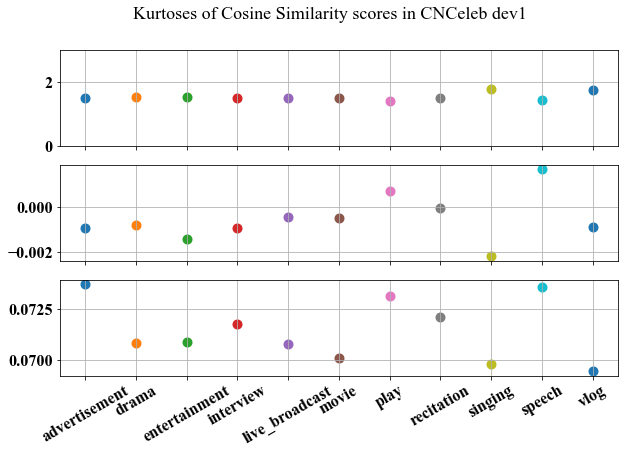

In [38]:
# x = np.arange(0, 2, 0.01)
plt.figure(figsize=(10,6))
plt.suptitle("Kurtoses of Cosine Similarity scores in CNCeleb dev1", fontsize=fontsize+2)
ax1 = plt.subplot(3,1,1)
ax2 = plt.subplot(3,1,2)
ax3 = plt.subplot(3,1,3)

other_train_domain_stats = {}
for i,dom in enumerate(domains):
    dom_cos = np.array(other_dom2cos[dom])
    
    mean = dom_cos.mean()
    diffs = dom_cos - mean
    var = np.mean(np.power(diffs, 2.0))
    std = np.power(var, 0.5)
    z_scores = diffs / std

    kurtoses = np.mean(np.power(z_scores, 4.0)) - 3.0
    
    ax1.scatter([dom], [kurtoses], marker='o', linewidth=4)
    ax2.scatter([dom], [mean], marker='o', linewidth=4)
    ax3.scatter([dom], [std], marker='o', linewidth=4)
    
    other_train_domain_stats[dom] = [mean, std]

ax1.set_xticklabels([])
ax1.set_ylim(0,3)
ax2.set_xticklabels([])

for ax in [ax1, ax2, ax3]:
    ax.grid()
    
    ax.tick_params(axis='x', labelrotation=30)
    ax.tick_params(axis='both', labelsize=fontsize)


In [143]:
scores = []
labels = []

for (s,l),d in zip(tdnn_test_scores, test_domain):
    s = (s-other_train_domain_stats[d][0]) / other_train_domain_stats[d][1]
    scores.append(s)
    if l == 'True':
        labels.append(True)
    else:
        labels.append(False)

domain_score = open('other_domain_scores', 'w')
with open(os.path.join(lstm_dir, 'cnceleb/test/trials'), 'r') as f:
    i = 0
    for l in f.readlines():
        enroll_uid, test_uid, _ = l.split()
        domain_score.write(enroll_uid + ' ' + test_uid + ' ' + str(scores[i]) +'\n')
        i += 1

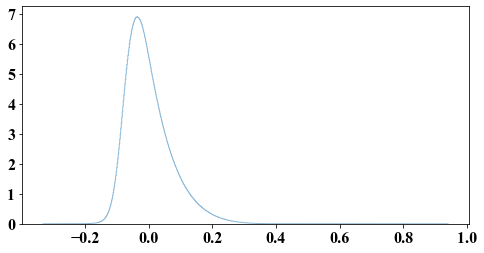

In [144]:
fontsize=16

plt.figure(figsize=(8, 3))

center2cos = np.array(all_othercos)

plt.hist(center2cos, alpha=0.5, bins=800, density=True, histtype='step')
_ = plt.yticks(fontsize=fontsize)
_ = plt.xticks(fontsize=fontsize)